# Titanic (Decision Trees)

This is a training notebook with basic ideas of ML.

**Summary**

* EDA
* Improving data
* Modelling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the dataset and create a DataFrame
# Se lee el dataset original como DataFrame

data_original = pd.read_csv("titanic2.csv")

# A look to the datatypes and null values
# Se exploran los tipos de variables del dataset y los valores faltantes

#data_original.describe()
print(data_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


### Description of features included in the dataset

* survival - Survival (0 = No; 1 = Yes)
* class - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* name - Name
* sex - Sex
* age - Age
* sibsp - Number of Siblings/Spouses Aboard
* parch - Number of Parents/Children Aboard
* ticket - Ticket Number
* fare - Passenger Fare
* cabin - Cabin
* embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
* **(not provided)** boat - Lifeboat (if survived)
* **(not provided)** body - Body number (if did not survive and body was recovered)

## Data understanding

In [3]:
# How the dataset looks like
# Cómo se ve el dataset

data_original.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Before going with EDA, here's a way of transforming original data to less memory-consuming data.

In [4]:
# Setting up the new data types
dtypes_col       = data_original.columns
dtypes_type_old  = data_original.dtypes
dtypes_type      = ['int16', 'bool','category','object','category','float32','int8','int8','object','float32','object','category']
optimized_dtypes = dict(zip(dtypes_col, dtypes_type))

# Reading the entire data, but now with optimized columns
data = pd.read_csv("titanic2.csv",dtype=optimized_dtypes)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    int16   
 1   Survived     891 non-null    bool    
 2   Pclass       891 non-null    category
 3   Name         891 non-null    object  
 4   Sex          891 non-null    category
 5   Age          714 non-null    float32 
 6   SibSp        891 non-null    int8    
 7   Parch        891 non-null    int8    
 8   Ticket       891 non-null    object  
 9   Fare         891 non-null    float32 
 10  Cabin        204 non-null    object  
 11  Embarked     889 non-null    category
dtypes: bool(1), category(3), float32(2), int16(1), int8(2), object(3)
memory usage: 35.3+ KB
None


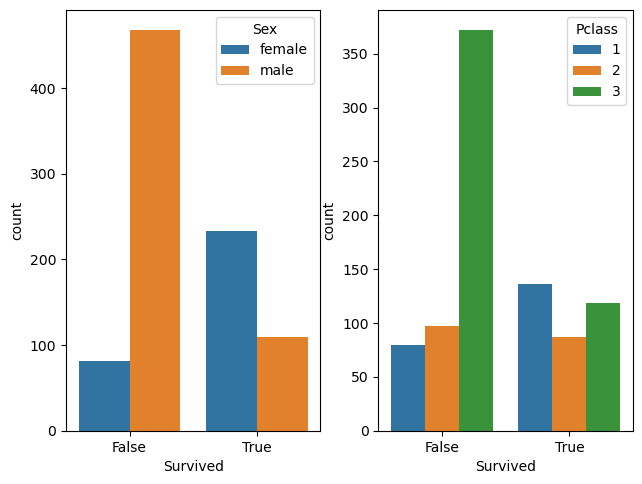

In [5]:
# Getting insights from survived

fig,axes= plt.subplots(1,2)
fig.tight_layout()
sns.countplot(x='Survived',hue='Sex',data=data,ax=axes[0])
sns.countplot(x='Survived',hue='Pclass',data=data,ax=axes[1])
plt.show()

In [6]:
# Specifically checking null values
# Revisando valores faltantes

data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

**Missing values** in Age, Cabin and Embarked.
<br>Age and Embark missing values should be filled.
<br>Cabin has a lot of missing values. Filling them might be biased. Then ignore Cabin.

**Valores faltantes** en Age, Cabin y Embarked.
<br>Los valores de Age y Embark se debería completar.
<br>Cabin se descarta por la alta cantidad de valores faltantes.

## Filling missing data

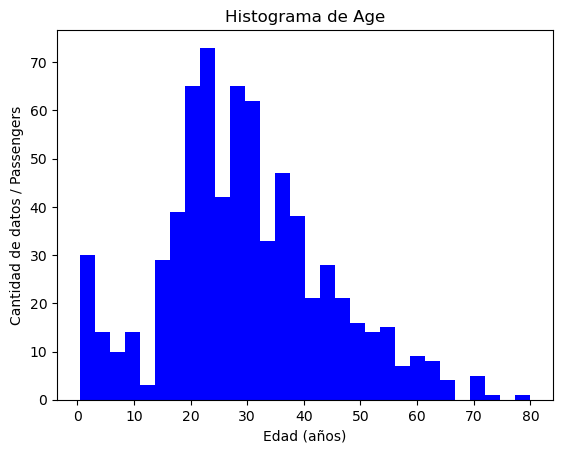

In [7]:
# Choice 1 (Easy): filling missing values with the Median of Age.
# Alternativa 1 (Básica): completar los faltantes con la mediana de Edad.

#data["Age"].fillna(data["Age"].median(), inplace = True)

# Choice 2 (Better): filling missing values taking the probability distribution of Age.
# Alternativa 2 (Más conveniente): completar los faltantes con valores tomados de la distribución de probabilidad de Age.

fig, ax = plt.subplots()
x = data["Age"].dropna()
hist, bins = np.histogram(x,bins=30)
ax.hist(x, bins= 30,color = 'blue')
ax.set_title('Histograma de Age')
ax.set_xlabel('Edad (años)')
ax.set_ylabel('Cantidad de datos / Passengers');

In [8]:
from random import choices

# Finding the probability of Age
bincenters = 0.5*(bins[1:]+bins[:-1])
probabilities = hist/hist.sum()

# Creating random numbers from existing age distribution
for item in data['Age']:
    data["Age_rand"] = data["Age"].apply(lambda v: np.random.choice(bincenters, p=probabilities))
    Age_null_list   = data[data["Age"].isnull()].index

    # Filling...   
    data.loc[Age_null_list,"Age"] = data.loc[Age_null_list,"Age_rand"]
    
data = data.drop(columns = ["Age_rand"])

In [9]:
# Checking null values
# Revisando valores faltantes
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
# Embarked could be filled with most popular category ("S"). Just becuase there are only 2 values missing.

# los 2 NaN de la columna Embarked se pueden reemplazar con S. Esto porque es la más popular y solo son 2 valores faltantes.

data["Embarked"] = data["Embarked"].fillna("S")
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

## Preparing for modelling

In [11]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,False,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250000,NaN,S
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283302,C85,C
2,3,True,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925000,NaN,S
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.099998,C123,S
4,5,False,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050000,NaN,S


In [12]:
# Using OneHot Encoder Sex will be transformed in two new columns: female and male

print('Valores originales en Sex:')
print(data["Sex"].unique())

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False, dtype=int)
data[['female', 'male']] = encoder.fit_transform(data[['Sex']])

Valores originales en Sex:
['male', 'female']
Categories (2, object): ['female', 'male']


C:\Users\usuario\anaconda3\envs\environment1\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:
# Now it is important to drop the column Sex

data = data.drop(['Sex'], axis=1)

In [14]:
data.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,female,male
0,1,False,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.250000,NaN,S,0,1
1,2,True,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.283302,C85,C,1,0
2,3,True,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.925000,NaN,S,1,0
3,4,True,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.099998,C123,S,1,0
4,5,False,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.050000,NaN,S,0,1


In [15]:
# label encoding - variable Embarked

print('Valores originales en Embarked:')
print(data["Embarked"].unique())

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

data["Embarked"]=le.fit_transform(data["Embarked"])
print('New values for Embarked:')
print(data["Embarked"].unique())

Valores originales en Embarked:
['S', 'C', 'Q']
Categories (3, object): ['C', 'Q', 'S']
New values for Embarked:
[2 0 1]


In [16]:
# label encoding - variable Pclass

print('Valores originales en Pclass:')
print(data["Pclass"].unique())

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

data["Pclass"]=le.fit_transform(data["Pclass"])
print('New values for Pclass:')
print(data["Pclass"].unique())

Valores originales en Pclass:
['3', '1', '2']
Categories (3, object): ['1', '2', '3']
New values for Pclass:
[2 0 1]


In [17]:
data.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,female,male
0,1,False,2,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.250000,NaN,2,0,1
1,2,True,0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.283302,C85,0,1,0
2,3,True,2,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.925000,NaN,2,1,0
3,4,True,0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.099998,C123,2,1,0
4,5,False,2,"Allen, Mr. William Henry",35.0,0,0,373450,8.050000,NaN,2,0,1


C:\Users\usuario\AppData\Local\Temp\ipykernel_16432\2723751501.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.drop(columns = ['Cabin','PassengerId']).corr()


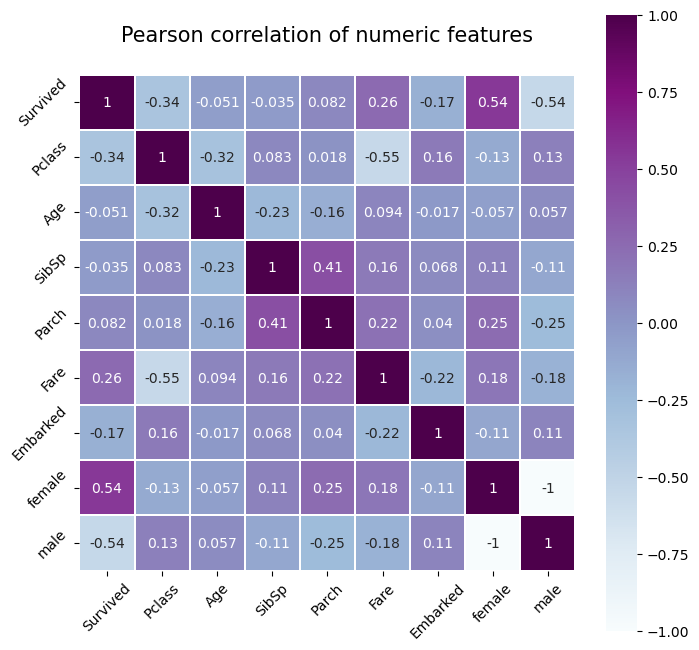

In [18]:
# Cabin shouldn't be included in the Correlation Matrix due to the missing values.

# No se debe usar el campo Cabin porque hay muchos datos faltantes.
# El Passenger Id is not relevant

corr = data.drop(columns = ['Cabin','PassengerId']).corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr,linewidths=0.1,vmax=1.0, square=True, cmap="BuPu", linecolor='white', annot=True)
plt.title('Pearson correlation of numeric features', y=1.05, size=15)
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()

**Interesting correlations:**

Sex -male and female- (-0.54), Pclass (-0.34), Fare (0.26)

In [19]:
# Sometimes it's worth to create groups of values. For instance, groups of Ages:
# A veces es útil crear agrupaciones de los valores de una variable. Por ejemplo Age:

#1: 0 a 12años
#2: 12 a 25
#3: 25 a 45
#4: >45

'''
fig, ax = plt.subplots()
plt.hist(data['Age'], bins=30, color='b')
ax.set(xlabel='Edades (años)', ylabel='Cantidad de datos / Passengers')
ax.set_title('Distribución de la edad de los pasajeros');

def formula(x):
    if x <= 12:
        return 1
    elif x > 12 and x <= 25:
        return 2
    elif x > 25 and x <= 45:
        return 3
    elif x > 45:
        return 4

data['age_group'] = data.apply(lambda row: formula(row['Age']), axis=1)

data['age_group'].value_counts()

'''

"\nfig, ax = plt.subplots()\nplt.hist(data['Age'], bins=30, color='b')\nax.set(xlabel='Edades (años)', ylabel='Cantidad de datos / Passengers')\nax.set_title('Distribución de la edad de los pasajeros');\n\ndef formula(x):\n    if x <= 12:\n        return 1\n    elif x > 12 and x <= 25:\n        return 2\n    elif x > 25 and x <= 45:\n        return 3\n    elif x > 45:\n        return 4\n\ndata['age_group'] = data.apply(lambda row: formula(row['Age']), axis=1)\n\ndata['age_group'].value_counts()\n\n"

## Modelling

### Model 1

In [20]:
# 1. Creating features and targets
# 1. Definición de variables predictoras y variable a predecir

X = data[['Pclass','Age','female','male','Embarked']]
y = data['Survived']

# 2. Splitting dataset into training data and validation data 
# 2. Separación de los datos en datos para entrenamiento y datos para validación

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Creating instance of the model
# 3. Instanciar el modelo

from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=None, splitter='best')

# 4. Training the model
# 4. Entrenar el modelo
tree.fit(X_train, y_train)

# 5. Predicting
# 5. Predecir

# Prediction using training data
y_train_pred = tree.predict(X_train)

# Predicción using validation data
y_test_pred = tree.predict(X_test)

# 6. Performance evaluation
from sklearn.metrics import accuracy_score

# Comparing with the real values
print('Accuracy sobre conjunto de Train:', accuracy_score(y_train_pred,y_train))
print('Accuracy sobre conjunto de Test:', accuracy_score(y_test_pred,y_test))

Accuracy sobre conjunto de Train: 0.9197431781701445
Accuracy sobre conjunto de Test: 0.7350746268656716


In [21]:
# Overfitting: cuando el error de entrenamiento es mayor al del testeo. Overfitting es alta varianza.

# El modelo solo tomará como válidos datos muy parecidos a los del conjunto de train.
# El modelo no reconocerá datos como buenos si está un poco por fuera de los rangos ya establecidos.

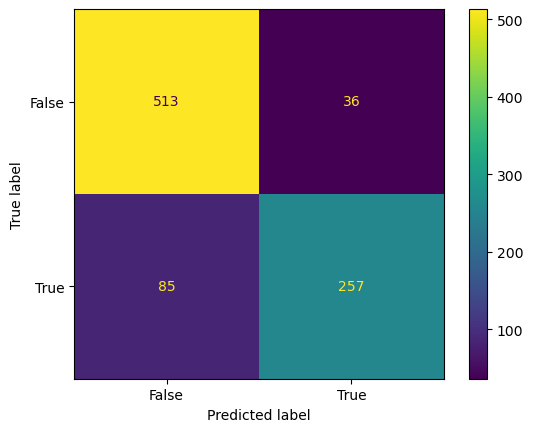

In [22]:
# Looking at the confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(tree,X,y);

Confusion matrix, without normalization
[[513  36]
 [ 85 257]]
Normalized confusion matrix
[[0.93442623 0.06557377]
 [0.24853801 0.75146199]]


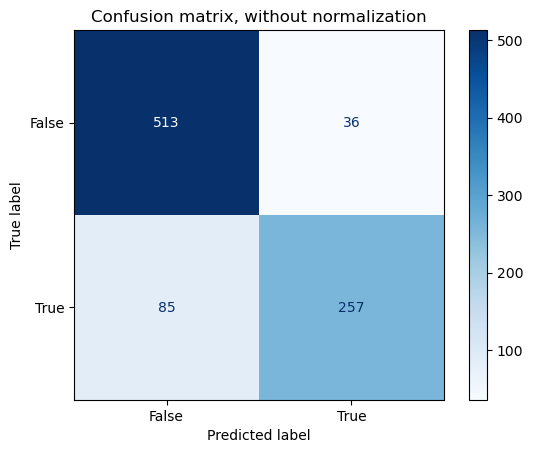

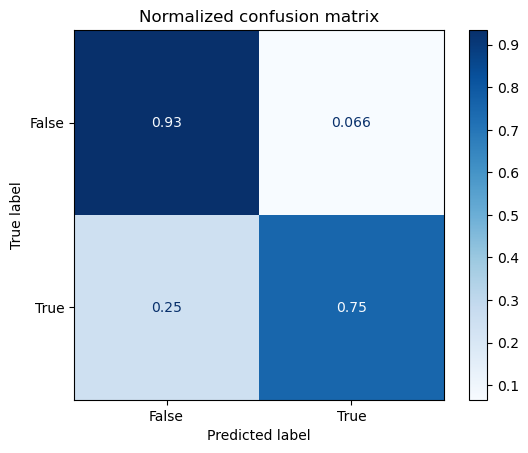

In [23]:
# Plot normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        tree,
        X,
        y,
        #display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

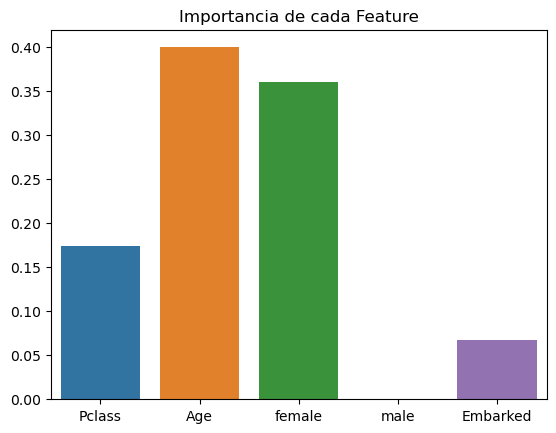

In [24]:
# Understanding feature importances

importances = tree.feature_importances_
columns = X.columns
sns.barplot(x=columns, y=importances)
plt.title('Importancia de cada Feature')
plt.show()

Embarked seems to be not very significant as feature for this case.

### Model 2

In [25]:
# 1. Creating features and targets
# 1. Definición de variables predictoras y variable a predecir

X2 = data[['Pclass','Age','female','male']]
y2 = data['Survived']

# 2. Splitting dataset into training data and validation data 
# 2. Separación de los datos en datos para entrenamiento y datos para validación

from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

# 3. Creating instance of the model
# 3. Instanciar el modelo

tree2 = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0,
                       random_state=None, splitter='best')

# 4. Training the model
# 4. Entrenar el modelo

tree2.fit(X2_train, y2_train)


# 5. Predicting
# 5. Predecir

# Prediction using training data
y_train_pred2 = tree2.predict(X2_train)

# Prediction using validation data
y_test_pred2 = tree2.predict(X2_test)


# 6. Performance evaluation
from sklearn.metrics import accuracy_score

# Comparing with the real values
print('Accuracy sobre conjunto Train:', accuracy_score(y_train_pred2,y2_train))
print('Accuracy sobre conjunto Test:', accuracy_score(y_test_pred2,y2_test))

Accuracy sobre conjunto Train: 0.8956661316211878
Accuracy sobre conjunto Test: 0.7350746268656716


Confusion matrix, without normalization
[[514  35]
 [101 241]]
Normalized confusion matrix
[[0.93624772 0.06375228]
 [0.29532164 0.70467836]]


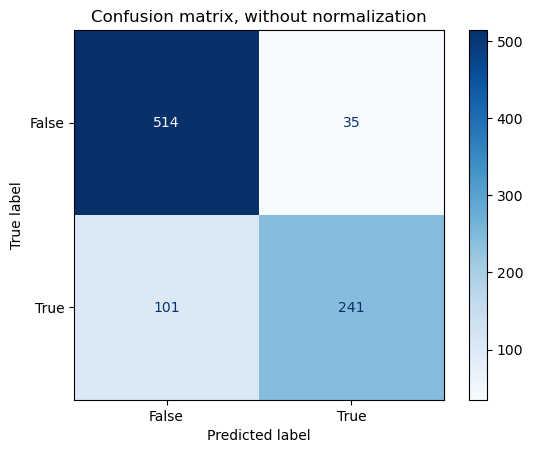

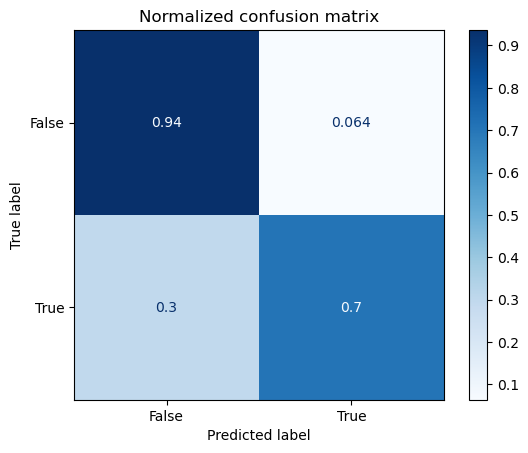

In [26]:
# Plot normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        tree2,
        X2,
        y2,
        #display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

### Model 3

Model 2 has less features than model 1, and the performance is almost the same.

Now it's worth trying to control overfitting using the least possible depth, but without significant reductions in performance.

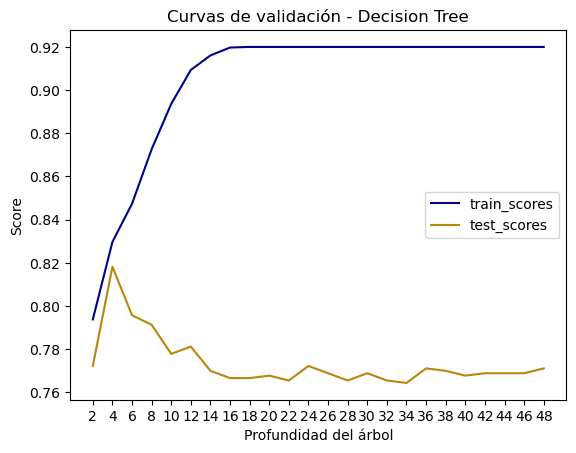

In [27]:
# Validation curve (from Scikit Learn):

# Defining a group of possible values for depth:
n = np.arange(2,50,2)

# Validation curve
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(DecisionTreeClassifier(),
                                           X,
                                           y,
                                           param_name='max_depth',
                                           param_range=n,
                                             cv=5)

# Se revisan los parámetros de profundidad a evaluar:
#np.mean(train_scores,axis=1).shape

plt.plot(np.mean(train_scores,axis=1),color='darkblue',label='train_scores')
plt.plot(np.mean(test_scores,axis=1),color='darkgoldenrod',label='test_scores')
plt.xlabel('Profundidad del árbol')
plt.ylabel('Score')
plt.title('Curvas de validación - Decision Tree')
plt.xticks(np.arange(24),n);
plt.legend()
plt.show()

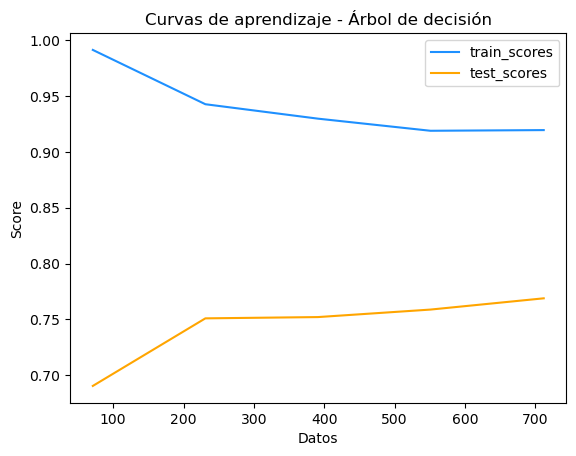

Pareciera que al modelo ya le falta poco por aprender.
La curva naranja (validation score) debería ser una asíntota. Pareciera que su pendiente ya no es muy alta.


In [28]:
# Learning curve

from sklearn.model_selection import learning_curve

learning_curve(DecisionTreeClassifier(max_depth=16),X,y,cv=5)

lc = learning_curve(DecisionTreeClassifier(max_depth=16),X,y,cv=5)
samples, train, test = lc[0], lc[1], lc[2]

plt.plot(samples,np.mean(train,axis=1),color='dodgerblue',label='train_scores')
plt.plot(samples,np.mean(test,axis=1),color='orange',label='test_scores');
plt.xlabel('Datos')
plt.ylabel('Score')
plt.title('Curvas de aprendizaje - Árbol de decisión')
plt.legend()
plt.show()

print('Pareciera que al modelo ya le falta poco por aprender.')
print('La curva naranja (validation score) debería ser una asíntota. Pareciera que su pendiente ya no es muy alta.')

In [29]:
# 1. Creating features and targets
# 1. Definición de variables predictoras y variable a predecir

X3 = data[['Pclass','Age','female','male']]
y3 = data['Survived']

# 2. Splitting dataset into training data and validation data 
# 2. Separación de los datos en datos para entrenamiento y datos para validación

from sklearn.model_selection import train_test_split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

# 3. Creating instance of the model
# 3. Instanciar el modelo

from sklearn.tree import DecisionTreeClassifier
profundidad = 6
tree3 = DecisionTreeClassifier(max_depth=profundidad)

# 4. Training the model
# 4. Entrenar el modelo

tree3.fit(X3_train, y3_train)

# 5. Predicting
tree3_pred = tree3.predict(X3_test)
tree3_ajuste = tree3.predict(X3_train)

# 6. Performance evaluation
from sklearn.metrics import accuracy_score

print('DecTree optimizado (prof. ' + str(profundidad) + ')')
print('Accuracy = ' + str(round(accuracy_score(tree3_ajuste,y3_train),8)) + ' en conjunto Train.')
print('Accuracy = ' + str(round(accuracy_score(tree3_pred,y3_test),8)) + ' en conjunto Test.')

DecTree optimizado (prof. 6)
Accuracy = 0.85072231 en conjunto Train.
Accuracy = 0.74626866 en conjunto Test.
